In [2]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [3]:
X = pd.read_csv("Clustering_Data.csv")
print(X.head())

   Alcohol  Malic_Acid   Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
0    14.23        1.71  2.43          15.6        127           2.80   
1    13.20        1.78  2.14          11.2        100           2.65   
2    13.16        2.36  2.67          18.6        101           2.80   
3    14.37        1.95  2.50          16.8        113           3.85   
4    13.24        2.59  2.87          21.0        118           2.80   

   Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  Color_Intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   OD280  Proline  Customer_Segment  
0   3.92     1065                 1  
1   3.40     105

In [4]:
X_mu = np.mean(X,axis=0)
X_sigma = np.std(X, axis=0)
X_sigma[X_sigma == 0] = 1  #replace zero standard deviations with 1 because all values identical(avoid division by 0)
X_norm = (X - X_mu)/X_sigma

In [37]:
class KMeans:

  def __init__(self, k, max_iters, tol=1e-6, plot_bool=False, random_state=None):
    self.k = k
    self.max_iters = max_iters
    self.tol = tol
    self.random_state = random_state
    self.plot_bool = plot_bool

    self.clusters = [[] for _ in range(self.k)]
    self.centroids = []

  def predict(self, X):
    self.X = X.to_numpy()
    self.m, self.n = X.shape

    if self.random_state:
      np.random.seed(self.random_state)

    random_sample_idxs = np.random.choice(self.m, self.k, replace=False) #list of non-repeating k ints ranging (0,m-1)
    self.centroids = self.X[random_sample_idxs]

    for _ in range(self.max_iters):
      self.clusters = self._create_clusters(self.centroids)

      if self.plot_bool:
        self.plot(iter=_)

      centroids_old = self.centroids
      self.centroids = self._get_centroids(self.clusters)

      if self._is_converged(centroids_old, self.centroids):
        break

    self.inertia = np.sum([np.sum((self.X[cluster] - self.centroids[i])**2) for i, cluster in enumerate(self.clusters)])

    return self._get_cluster_labels(self.clusters)

  def _create_clusters(self, centroids):
    clusters = [[] for _ in range(self.k)]
    for idx, sample in enumerate(self.X):
      centroid_idx = self._closest_centroid(sample, centroids)
      clusters[centroid_idx].append(idx)
    return clusters

  def _closest_centroid(self, sample, centroids):
    distances = np.linalg.norm(sample-centroids, axis=1)
    return np.argmin(distances)

  def _get_centroids(self, clusters):
    centroids = np.zeros((self.k, self.n))
    for idx, cluster in enumerate(clusters):
      if cluster:  #avoid empty clusters
        centroids[idx] = np.mean(self.X[cluster], axis=0)
      else:
        centroids[idx] = self.X[np.random.choice(self.m)]

    return centroids

  def _is_converged(self, centroids_old, centroids):
    distance = np.linalg.norm(centroids_old-centroids)
    return distance < self.tol

  def plot(self, iter):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(self.X)
    reduced_centroids = pca.transform(self.centroids)

    plt.figure(figsize=(8, 6))
    for cluster_idx, cluster in enumerate(self.clusters):
      cluster_points = reduced_data[cluster]
      plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_idx}")

      # Plot centroids
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], s=300, c='red', marker='x', label='Centroids')

    plt.title(f"K-Means Clustering (PCA Reduced) Iteration {iter+1}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()


  def _get_cluster_labels(self, clusters):
    labels = np.empty(self.m)
    for idx, cluster in enumerate(clusters):
      for sample_idx in cluster:
        labels[sample_idx] = idx
    return labels

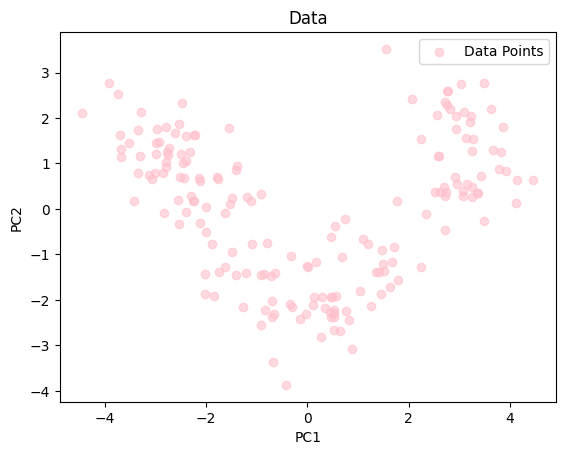

In [33]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(X_norm)
plt.scatter(data_pca[:,0],data_pca[:,1],alpha=0.6, color='pink', label='Data Points')
plt.title('Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

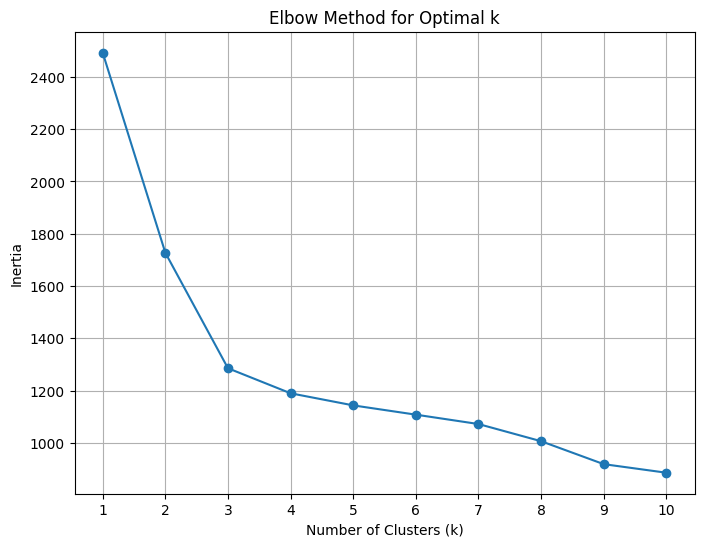

In [41]:
max_k = 10
inertias = []
for k in range(1, max_k+1):
  kmeans = KMeans(k, 100, random_state=42)
  kmeans.predict(X_norm)
  inertias.append(kmeans.inertia)

plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k + 1), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, max_k + 1))
plt.grid()
plt.show()

Clearly, elbow is at k=3, so we use k=3 for prediction.

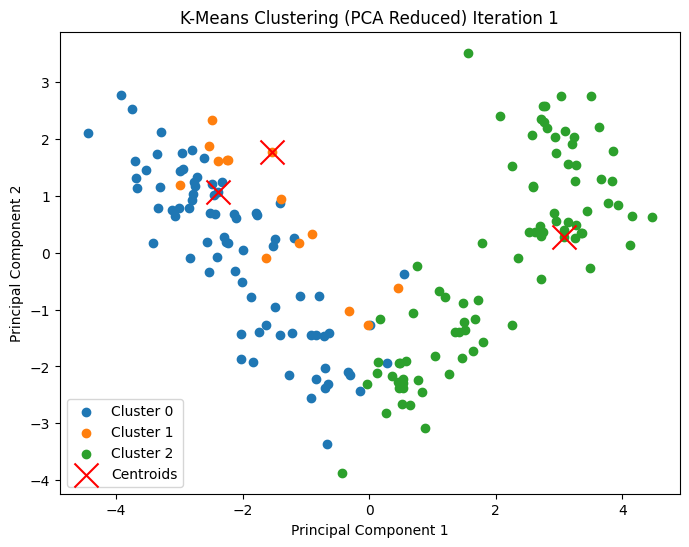

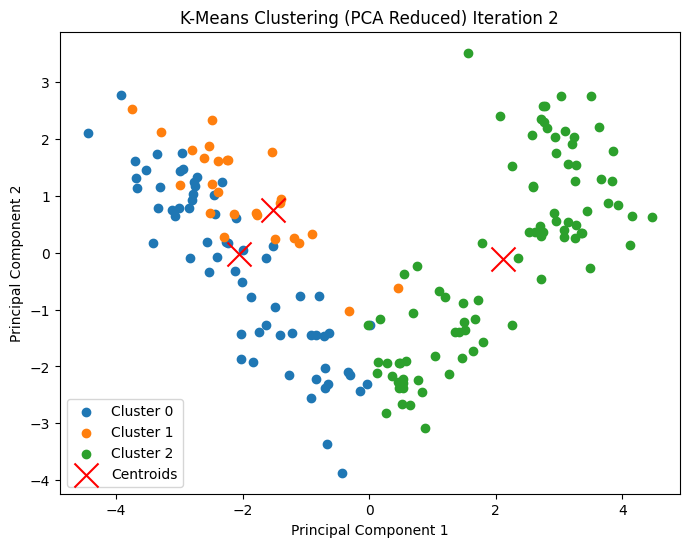

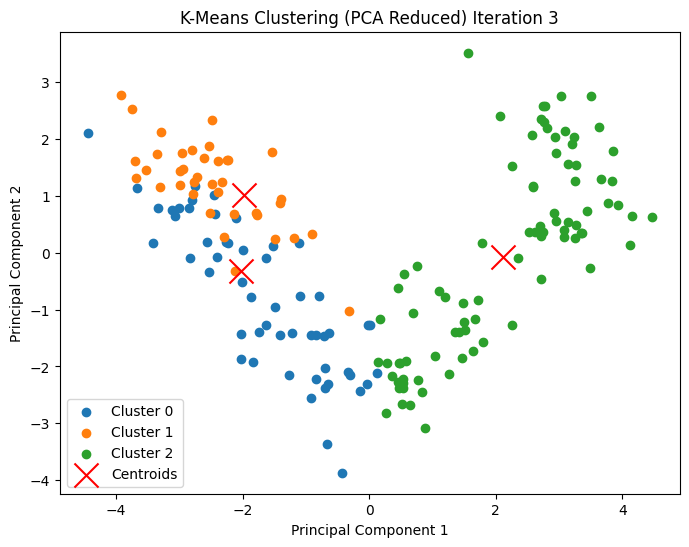

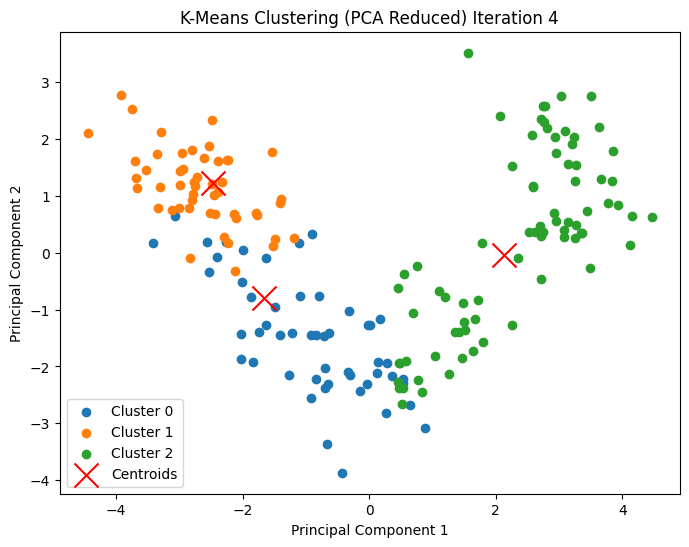

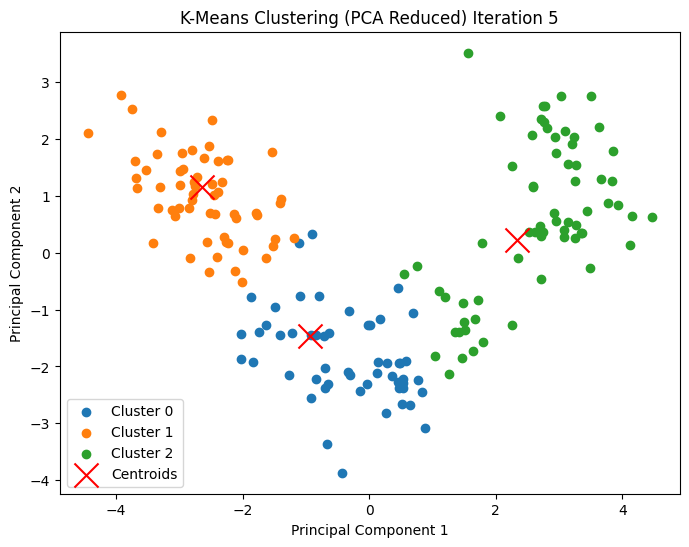

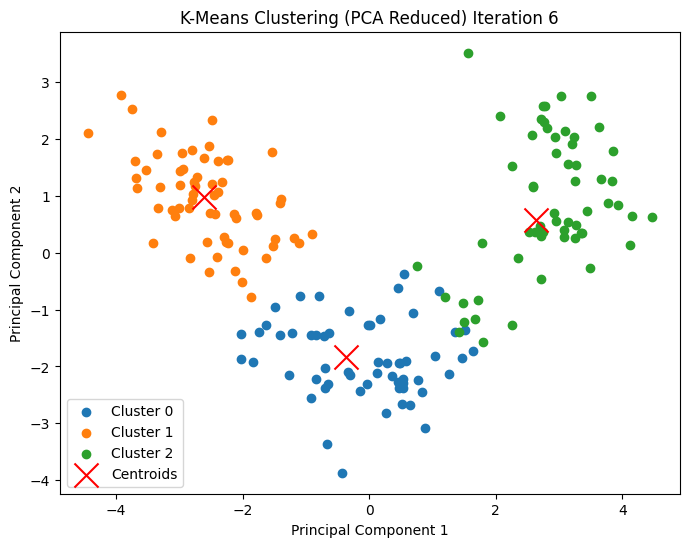

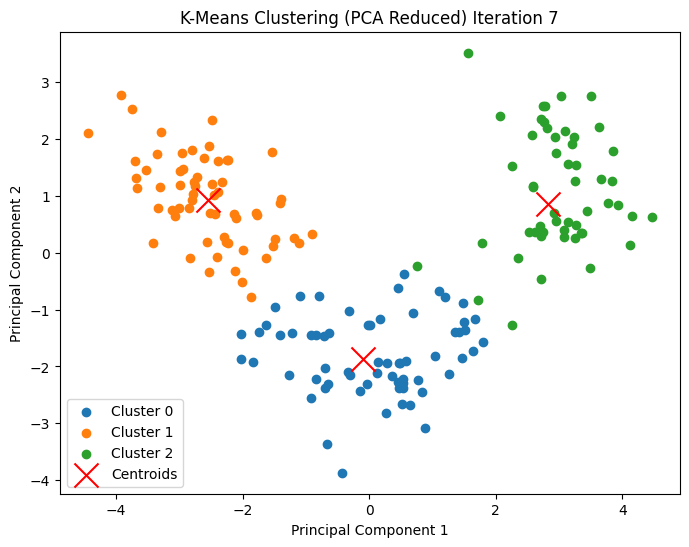

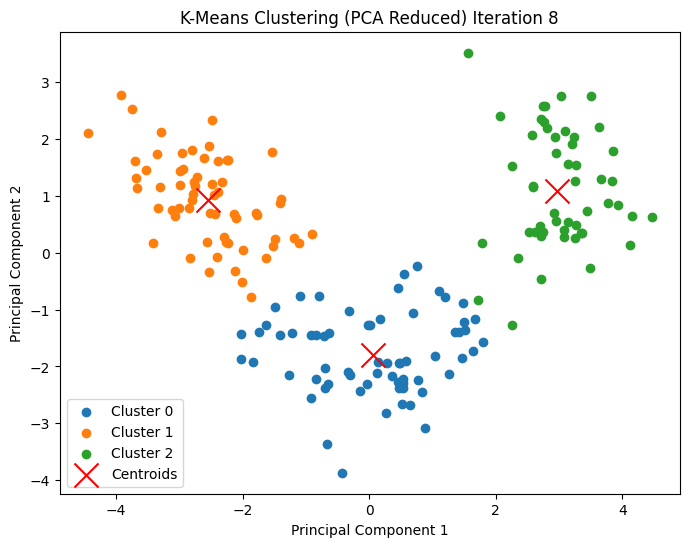

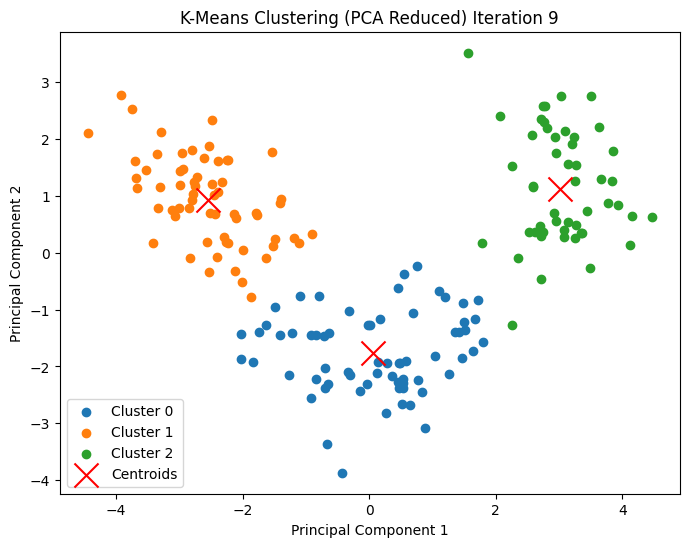

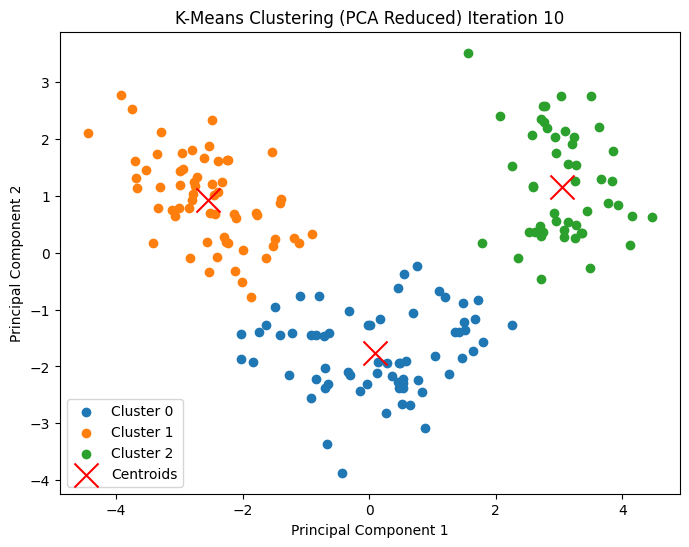

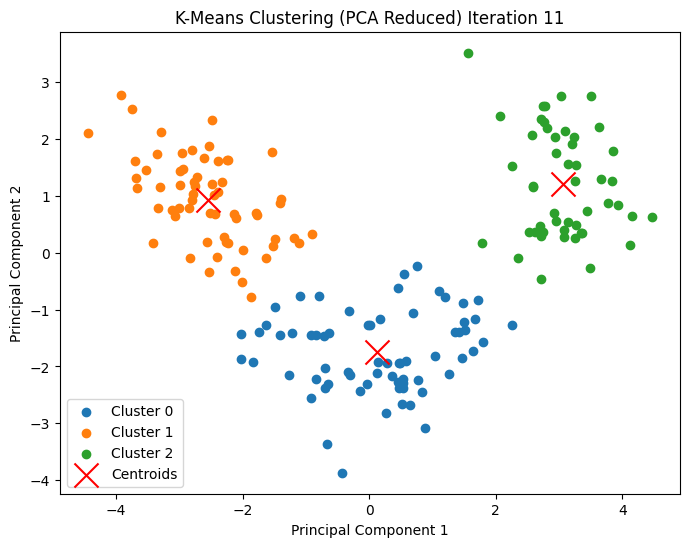

In [42]:
kmeans = KMeans(3, 300, plot_bool=True, random_state=42)
y_pred = kmeans.predict(X_norm)

In [43]:
print(f"Inertia = {kmeans.inertia}")

Inertia = 1285.6677396078076
